# Feature Extract

Usage: function plotting will plot rmsd, rmsd histogram, rmsf and PCA projection

## Import packages

In [2]:
from __future__ import print_function
%matplotlib inline
import mdtraj as md
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import pandas as pd
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')
import MDAnalysis as mda
#XRD Ensemble
#28 4NPQ
#18 4HFI
residue_selection = 'resSeq 8 to 316'

## Define global variables

In [3]:
traj_notes = ['5NJY_pH70_md1','5NJY_pH70_md2','5NJY_pH70_md3','5NJY_F238L_pH70_md1',
                 '5NJY_F238L_pH70_md2','5NJY_F238L_pH70_md3','5NJY_I233T_pH70_md4',
                  '5NJY_I233T_pH70_md2','5NJY_I233T_pH70_md3','5NJY_F238LI233T_pH70_md1',
                  '5NJY_F238LI233T_pH70_md2','5NJY_F238LI233T_pH70_md3','5NJY_pH46_md1','5NJY_pH46_md2','5NJY_pH46_md3','5NJY_F238L_pH46_md1',
                 '5NJY_F238L_pH46_md2','5NJY_F238L_pH46_md3','5NJY_I233T_pH46_md1',
                  '5NJY_I233T_pH46_md2','5NJY_I233T_pH46_md3','5NJY_F238LI233T_pH46_md1',
                  '5NJY_F238LI233T_pH46_md2','5NJY_F238LI233T_pH46_md3','4HFI_pH46_md1','4HFI_pH46_md2','4HFI_pH46_md3','4HFI_F238L_pH46_md1',
                 '4HFI_F238L_pH46_md2','4HFI_F238L_pH46_md3','4HFI_I233T_pH46_md1',
                  '4HFI_I233T_pH46_md2','4HFI_I233T_pH46_md3','4HFI_F238LI233T_pH46_md1',
                  '4HFI_F238LI233T_pH46_md2','4HFI_F238LI233T_pH46_md3','4NPQ_pH70_md5','4NPQ_pH70_md6','4NPQ_pH70_md7','4NPQ_F238L_pH70_md3',
                 '4NPQ_F238L_pH70_md4','4NPQ_F238L_pH70_md5','4NPQ_I233T_pH70_md3',
                  '4NPQ_I233T_pH70_md4','4NPQ_I233T_pH70_md5','4NPQ_F238LI233T_pH70_md3',
                  '4NPQ_F238LI233T_pH70_md4','4NPQ_F238LI233T_pH70_md5']

## Functions

### Basic Notations

In [3]:
def create_md_dataframe():    
    md_data = pd.DataFrame(columns=list(['MD_name','pH','replicate','traj_time']))
    return md_data

In [4]:
def create_metadata(md_data= None):   
    def append_metadata(traj_note,location = '/media/scottzhuang/data/MD/',skip=10,md_data= md_data):
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        if skip == 1:
            traj = md.load(location + traj_location,top= location + top_location,stride=10)
        else:
            traj = md.load(location + traj_location,top= location + top_location)
        print("In " + traj_note + ", simulation runs " + str(10 * traj.n_frames) + " ns.")
        md_name = traj_note[:traj_note.find('pH')-1]
        pH = traj_note[traj_note.find('pH')+2:traj_note.find('pH')+4]
        md_replicate = traj_note[-1]
        for i in range(0,traj.n_frames):
            md_data.loc[md_data.shape[0]+1] = [md_name,pH,md_replicate,i]

    for traj_note in traj_notes:
        append_metadata(traj_note)

In [24]:
def create_system_notation(md_data = None):
    system_notation = 0
    notation = -1
    location = '/media/scottzhuang/data/MD/'
    skip=10
    notations = []
    increment = 0
    for traj_note in traj_notes:
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top= location + top_location)
        if traj_note.find('md1') >= 0:
            notation = notation + 1
        if traj_note == '5NJY_I233T_pH70_md4' or traj_note == '4NPQ_pH70_md5' or  traj_note == '4NPQ_F238L_pH70_md3' or traj_note == '4NPQ_I233T_pH70_md3' or traj_note == '4NPQ_F238LI233T_pH70_md3' or traj_note == '4HFI_F238L_pH46_md4':
            notation = notation + 1

        for frame in range(0,traj.n_frames):
            notations.append(notation)
        #if increment % 3 == 2:
        #    notation = notation + 1
        #increment = increment + 1 
        
    md_data['system'] = notations

In [6]:
def create_cluster_data(md_data = None):
    cluster_index = []
    def add_cluster_data(traj_note,location = '/media/scottzhuang/data/MD/',skip=10):
        cluster_data = pd.read_pickle(location + traj_note + '/ward_cluster_labels.pickle')
        cluster_index.extend(cluster_data)
    for traj_note in traj_notes:
        add_cluster_data(traj_note)
    md_data['cluster_index'] = cluster_index

### Basic Features

In [117]:
def create_rmsd_data(md_data= None,ref_name = None,select_domain = None):
    def append_rmsd_data(traj_note,location = '/media/scottzhuang/data/MD/',ref_name = None, skip=10):
        residue_selection_1 = "resSeq 13 to 198"
        residue_selection_2 = "resSeq 198 to 316"
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top= location + top_location)
        if select_domain == 'TMD':
            traj = traj.atom_slice(traj.topology.select(residue_selection_2))
        elif select_domain == 'ECD':
            traj = traj.atom_slice(traj.topology.select(residue_selection_1))

        if ref_name != None:
            ref_location = ("/home/scottzhuang/masterthesis/miscellanies/pdb_ensemble/" + ref_name + "_1.mer.pdb")
        else:
            ref_location = location + top_location
        ref_traj = md.load(ref_location)
        if select_domain == 'TMD':
            ref_traj = ref_traj.atom_slice(ref_traj.topology.select(residue_selection_2))
        elif select_domain == 'ECD':
            ref_traj = ref_traj.atom_slice(ref_traj.topology.select(residue_selection_1))
        if traj.n_atoms != ref_traj.n_atoms:
            traj = traj.atom_slice(traj.topology.select(residue_selection))
        traj.superpose(ref_traj,0)
        rmsd_data.extend(list(md.rmsd(traj, ref_traj)*10))
    rmsd_data = []
    for traj_note in traj_notes:
        append_rmsd_data(traj_note,ref_name = ref_name)
    if select_domain == 'TMD':
        md_data['tmd_rmsd']= rmsd_data
    elif select_domain == 'ECD':
        md_data['ecd_rmsd']= rmsd_data
    elif ref_name != None:
        md_data['rmsd' + str(ref_name)]= rmsd_data
    else:
        md_data['rmsd']= rmsd_data

In [30]:
create_selection_rmsd_data(md_data,'4HFI')

In [191]:
def create_cppca_data_m2(md_data = None,residue_selection_2 = "(resSeq 230 to 250)"):
    def combined_ppca_reduced_cartesian(residue_selection_2 = "(resSeq 230 to 250)"):
        wholetraj = md.load("/home/scottzhuang/masterthesis/miscellanies/pdb_ensemble/new_ensemble.pdb")
        wholetraj.superpose(wholetraj,18)
        topology = wholetraj.topology
        wholetraj_sliced_tmd = wholetraj.atom_slice(topology.select(residue_selection_2))
        wholetraj_sliced_tmd.superpose(wholetraj_sliced_tmd,18)
        ppca_tmd = PCA(n_components=5)
        ppca_tmd.fit(wholetraj_sliced_tmd.xyz.reshape(wholetraj_sliced_tmd.n_frames, wholetraj_sliced_tmd.n_atoms * 3))
        print(ppca_tmd.explained_variance_ratio_)
        return wholetraj_sliced_tmd, ppca_tmd
    
    def append_projection_on_combined_ppca_data(traj_note, location = '/media/scottzhuang/data/MD/',skip = 10, residue_selection_2 = "(resSeq 230 to 250)"):
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top= location + top_location)
        topology = traj.topology
        traj_sliced_tmd = traj.atom_slice(topology.select(residue_selection_2))
        traj_sliced_tmd.superpose(wholetraj_sliced_tmd,18)
        reduced_cartesian_tmd_pc1.extend(ppca_tmd.transform(traj_sliced_tmd.xyz.reshape(traj_sliced_tmd.n_frames, traj_sliced_tmd.n_atoms * 3)).T[0])
        reduced_cartesian_tmd_pc2.extend(ppca_tmd.transform(traj_sliced_tmd.xyz.reshape(traj_sliced_tmd.n_frames, traj_sliced_tmd.n_atoms * 3)).T[1])
        reduced_cartesian_tmd_pc3.extend(ppca_tmd.transform(traj_sliced_tmd.xyz.reshape(traj_sliced_tmd.n_frames, traj_sliced_tmd.n_atoms * 3)).T[2])
        reduced_cartesian_tmd_pc4.extend(ppca_tmd.transform(traj_sliced_tmd.xyz.reshape(traj_sliced_tmd.n_frames, traj_sliced_tmd.n_atoms * 3)).T[3])
        reduced_cartesian_tmd_pc5.extend(ppca_tmd.transform(traj_sliced_tmd.xyz.reshape(traj_sliced_tmd.n_frames, traj_sliced_tmd.n_atoms * 3)).T[4])

    wholetraj_sliced_tmd,ppca_tmd = combined_ppca_reduced_cartesian(residue_selection_2)
    
    reduced_cartesian_tmd_pc1 = []
    reduced_cartesian_tmd_pc2 = []
    reduced_cartesian_tmd_pc3 = []
    reduced_cartesian_tmd_pc4 = []
    reduced_cartesian_tmd_pc5 = []


    for traj_note in traj_notes:
        append_projection_on_combined_ppca_data(traj_note)
    md_data['m2_pc1']= reduced_cartesian_tmd_pc1
    md_data['m2_pc2']= reduced_cartesian_tmd_pc2
    md_data['m2_pc3']= reduced_cartesian_tmd_pc3
    md_data['m2_pc4']= reduced_cartesian_tmd_pc4
    md_data['m2_pc5']= reduced_cartesian_tmd_pc5
    

In [192]:
create_cppca_data_m2(md_data)

[ 0.73159707  0.18387465  0.0516021   0.00936811  0.00758874]


In [193]:
md_data.columns

Index(['MD_name', 'pH', 'replicate', 'traj_time', 'system', 'ecd_pc1',
       'ecd_pc2', 'tmd_pc1', 'tmd_pc2', 'wholepca_pc1', 'wholepca_pc2',
       'wholepca_pc3', 'wholepca_pc4', 'wholepca_pc5', 'domain twist',
       'helix tilt angle', 'helix twist angle', 'beta_expansion', 'M2_radius',
       'ECD_radius', 'M2_M1_distance', 'M1_kink', 'hydration_data',
       'hydration_data235_3a', 'hydration_data233_3a', 'hydration_data238_3a',
       'hydration_data226_3a', 'hydration_data240_3a', 'hydration_data_m123',
       'pore_profile_222', 'pore_profile_226', 'pore_profile_230',
       'pore_profile_233', 'pore_profile_237', 'pore_profile_240', 'rmsd4NPQ',
       'rmsd4HFI', 'rmsd5NJY', 'tmd_rmsd', 'ecd_rmsd', 'rmsd', 'cluster_index',
       'ECD twist', 'hydration_data_236_center', 'tmd_noM2_pc1',
       'tmd_noM2_pc2', 'rmsd_TMD_noM2', 'contact_238_246',
       'ecd_pc1_no_expansion', 'ecd_pc2_no_expansion', 'dbscan', 'm2_pc1',
       'm2_pc2', 'm2_pc3', 'm2_pc4', 'm2_pc5'],
      dty

In [21]:
def create_cppca_data(md_data = None,residue_selection_1 = "resSeq 13 to 198", residue_selection_2 = "resSeq 198 to 316"):
    def combined_ppca_reduced_cartesian(residue_selection_1 = "resSeq 13 to 198", residue_selection_2 = "resSeq 198 to 316"):
        wholetraj = md.load("/home/scottzhuang/masterthesis/miscellanies/pdb_ensemble/new_ensemble.pdb")
        wholetraj.superpose(wholetraj,18)
        topology = wholetraj.topology
        wholetraj_sliced_ecd = wholetraj.atom_slice(topology.select(residue_selection_1))
        wholetraj_sliced_ecd.superpose(wholetraj_sliced_ecd,18)
        wholetraj_sliced_tmd = wholetraj.atom_slice(topology.select(residue_selection_2))
        wholetraj_sliced_tmd.superpose(wholetraj_sliced_tmd,18)
        ppca_ecd = PCA(n_components=2)
        ppca_tmd = PCA(n_components=2)
        partial_reduced_cartesian = [ppca_ecd.fit_transform(wholetraj_sliced_ecd.xyz.reshape(wholetraj_sliced_ecd.n_frames, wholetraj_sliced_ecd.n_atoms * 3)), ppca_tmd.fit_transform(wholetraj_sliced_tmd.xyz.reshape(wholetraj_sliced_tmd.n_frames, wholetraj_sliced_tmd.n_atoms * 3))]    
        return partial_reduced_cartesian, wholetraj_sliced_ecd, wholetraj_sliced_tmd,ppca_ecd,ppca_tmd
    
    def append_projection_on_combined_ppca_data(traj_note, location = '/media/scottzhuang/data/MD/',skip = 10, residue_selection_1 = "resSeq 13 to 198", residue_selection_2 = "resSeq 198 to 316"):
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top= location + top_location)
        topology = traj.topology
        traj_sliced_ecd = traj.atom_slice(topology.select(residue_selection_1))
        traj_sliced_tmd = traj.atom_slice(topology.select(residue_selection_2))

        traj_sliced_ecd.superpose(wholetraj_sliced_ecd,18)
        traj_sliced_tmd.superpose(wholetraj_sliced_tmd,18)

        reduced_cartesian_ecd_pc1.extend(ppca_ecd.transform(traj_sliced_ecd.xyz.reshape(traj_sliced_ecd.n_frames, traj_sliced_ecd.n_atoms * 3)).T[0])
        reduced_cartesian_ecd_pc2.extend(ppca_ecd.transform(traj_sliced_ecd.xyz.reshape(traj_sliced_ecd.n_frames, traj_sliced_ecd.n_atoms * 3)).T[1])
        reduced_cartesian_tmd_pc1.extend(ppca_tmd.transform(traj_sliced_tmd.xyz.reshape(traj_sliced_tmd.n_frames, traj_sliced_tmd.n_atoms * 3)).T[0])
        reduced_cartesian_tmd_pc2.extend(ppca_tmd.transform(traj_sliced_tmd.xyz.reshape(traj_sliced_tmd.n_frames, traj_sliced_tmd.n_atoms * 3)).T[1])

    partial_reduced_cartesian, wholetraj_sliced_ecd,wholetraj_sliced_tmd, ppca_ecd,ppca_tmd = combined_ppca_reduced_cartesian(residue_selection_1,residue_selection_2)
    
    reduced_cartesian_ecd_pc1 = []
    reduced_cartesian_ecd_pc2 = []
    reduced_cartesian_tmd_pc1 = []
    reduced_cartesian_tmd_pc2 = []

    for traj_note in traj_notes:
        append_projection_on_combined_ppca_data(traj_note)
    md_data['ecd_pc1']= reduced_cartesian_ecd_pc1
    md_data['ecd_pc2']= reduced_cartesian_ecd_pc2
    md_data['tmd_pc1']= reduced_cartesian_tmd_pc1
    md_data['tmd_pc2']= reduced_cartesian_tmd_pc2

In [149]:
md_data.columns

Index(['MD_name', 'pH', 'replicate', 'traj_time', 'system', 'ecd_pc1',
       'ecd_pc2', 'tmd_pc1', 'tmd_pc2', 'wholepca_pc1', 'wholepca_pc2',
       'wholepca_pc3', 'wholepca_pc4', 'wholepca_pc5', 'domain twist',
       'helix tilt angle', 'helix twist angle', 'beta_expansion', 'M2_radius',
       'ECD_radius', 'M2_M1_distance', 'M1_kink', 'hydration_data',
       'hydration_data235_3a', 'hydration_data233_3a', 'hydration_data238_3a',
       'hydration_data226_3a', 'hydration_data240_3a', 'hydration_data_m123',
       'pore_profile_222', 'pore_profile_226', 'pore_profile_230',
       'pore_profile_233', 'pore_profile_237', 'pore_profile_240', 'rmsd4NPQ',
       'rmsd4HFI', 'rmsd5NJY', 'tmd_rmsd', 'ecd_rmsd', 'rmsd', 'cluster_index',
       'ECD twist', 'hydration_data_236_center', 'tmd_noM2_pc1',
       'tmd_noM2_pc2', 'rmsd_TMD_noM2', 'contact_238_246',
       'ecd_pc1_no_expansion', 'ecd_pc2_no_expansion'],
      dtype='object')

In [69]:
def create_pca_data(md_data = None):
    def ensemble_pca_cartesian():
        wholetraj = md.load("/home/scottzhuang/masterthesis/miscellanies/pdb_ensemble/new_ensemble.pdb")
        wholetraj = wholetraj.atom_slice(wholetraj.topology.select("resSeq 13 to 316"))
        wholetraj.superpose(wholetraj,18)
        pca = PCA(n_components=5)
        reduced_cartesian = pca.fit_transform(wholetraj.xyz.reshape(wholetraj.n_frames,wholetraj.n_atoms *3))
        return wholetraj, pca
    def append_pca_data(traj_note,location = '/media/scottzhuang/data/MD/',skip = 10):
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top =location + top_location)
        topology = traj.topology
        traj = traj.atom_slice(topology.select("resSeq 13 to 316"))
        traj.superpose(wholetraj,18)
        traj_reduced_cartesian = pca.transform(traj.xyz.reshape(traj.n_frames,traj.n_atoms * 3))
        pca1.extend(traj_reduced_cartesian.T[0])
        pca2.extend(traj_reduced_cartesian.T[1])
        pca3.extend(traj_reduced_cartesian.T[2])
        pca4.extend(traj_reduced_cartesian.T[3])
        pca5.extend(traj_reduced_cartesian.T[4])


    pca1 = []
    pca2 = []
    pca3 = []
    pca4 = []
    pca5 = []
    wholetraj, pca = ensemble_pca_cartesian()
    for traj_note in traj_notes:
        append_pca_data(traj_note)
    md_data['wholepca_pc1'] = pca1
    md_data['wholepca_pc2'] = pca2
    md_data['wholepca_pc3'] = pca3
    md_data['wholepca_pc4'] = pca4
    md_data['wholepca_pc5'] = pca5


### Gating-related geometries

In [14]:
def create_domain_twist_data(md_data = None):
    def append_domain_twist(traj_note,location = '/media/scottzhuang/data/MD/',skip = 10):
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top= location + top_location)        
        traj.superpose(traj,0)
        topology = traj.topology
        domain_twist = []
        for chain in range (0,5):
            residue_selection_1 = "resid " + str(8+chain*311) + " to " + str(192+chain*311)
            residue_selection_2 = "resid " + str(192+chain*311) + " to " + str(310+chain*311)
            traj_sliced_ecd = traj.atom_slice(topology.select(residue_selection_1))
            traj_sliced_tmd = traj.atom_slice(topology.select(residue_selection_2))
            angle = []
            for i in range(0,traj.n_frames):
                cen_mass_ecd = md.compute_center_of_mass(traj_sliced_ecd[i])[0]
                cen_mass_tmd = md.compute_center_of_mass(traj_sliced_tmd[i])[0]
                cen_mass = md.compute_center_of_mass(traj[i])[0]
                cen_mass_ecd[2] = cen_mass[2]
                cen_mass_tmd[2] = cen_mass[2]
                vec_ecd = cen_mass_ecd - cen_mass
                vec_tmd = cen_mass_tmd - cen_mass
                veclength_ecd = np.sqrt(np.sum(np.power(vec_ecd,2)))
                veclength_tmd = np.sqrt(np.sum(np.power(vec_tmd,2)))
                angle.append(57.2958 * np.arccos(np.dot(vec_ecd,vec_tmd) /(veclength_ecd * veclength_tmd)))
            print(angle)
            domain_twist.append(angle)
        domain_twist_data.extend(np.mean(np.asarray(domain_twist),axis=0))
    domain_twist_data = []
    for traj_note in traj_notes:
        append_domain_twist(traj_note)
    md_data['domain twist']= domain_twist_data

In [25]:
def create_ecd_twist_data(md_data = None):
    def wiki_dihedral(p):
        p0 = p[0]
        p1 = p[1]
        p2 = p[2]
        p3 = p[3]
        b0 = -1.0*(p1 - p0)
        b1 = p2 - p1
        b2 = p3 - p2
        b0xb1 = np.cross(b0, b1)
        b1xb2 = np.cross(b2, b1)
        b0xb1_x_b1xb2 = np.cross(b0xb1, b1xb2)

        y = np.dot(b0xb1_x_b1xb2, b1)*(1.0/np.linalg.norm(b1))
        x = np.dot(b0xb1, b1xb2)
        return np.degrees(np.arctan2(y, x))

    def append_ecd_twist(traj_note,location = '/media/scottzhuang/data/MD/',skip = 10):
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top= location + top_location)        
        traj.superpose(traj,0)
        topology = traj.topology
        residue_selection_1 = "resSeq 13 to 198"
        residue_selection_2 = "resSeq 198 to 316"
        traj_sliced_ecd = traj.atom_slice(topology.select(residue_selection_1))
        traj_sliced_tmd = traj.atom_slice(topology.select(residue_selection_2))
        
        ecd_twist = []
        for chain in range (0,5):
            di_angle = []

            for i in range(0,traj.n_frames):
                cen_mass_ecd = md.compute_center_of_mass(traj_sliced_ecd[i])[0]
                cen_mass_tmd = md.compute_center_of_mass(traj_sliced_tmd[i])[0]
                residue_selection_3 = "resid " + str(8+chain*311) + " to " + str(192+chain*311)
                residue_selection_4 = "resid " + str(192+chain*311) + " to " + str(310+chain*311)
                traj_sliced_ecd_chain = traj.atom_slice(topology.select(residue_selection_3))
                traj_sliced_tmd_chain = traj.atom_slice(topology.select(residue_selection_4))
                cen_mass_ecd_chain = md.compute_center_of_mass(traj_sliced_ecd_chain[i])[0]
                cen_mass_tmd_chain = md.compute_center_of_mass(traj_sliced_tmd_chain[i])[0]
                di_angle.append(wiki_dihedral(np.asarray([(cen_mass_ecd_chain).tolist(),(cen_mass_ecd).tolist(),(cen_mass_tmd).tolist(),(cen_mass_tmd_chain).tolist()])))
            ecd_twist.append(di_angle)
        ecd_twist_data.extend(np.mean(np.asarray(ecd_twist),axis=0))
    ecd_twist_data = []
    for traj_note in traj_notes:
        append_ecd_twist(traj_note)
    md_data['ECD twist']= ecd_twist_data

In [26]:
create_ecd_twist_data(md_data)

In [3]:
def create_helix_tilt_data(md_data = None):
    def append_helix_tilt_data(traj_note,location = '/media/scottzhuang/data/MD/', skip=10):
        tilt_data = pd.read_csv(location + traj_note + '/' + traj_note + '.tilt.csv',sep=" ")
        tilt_data.columns = ['traj_time','avg','ang1','ang2','ang3','ang4','ang5']
        helix_tilt_data.extend(tilt_data['avg'])
    helix_tilt_data = []
    for traj_note in traj_notes:
        append_helix_tilt_data(traj_note)
    md_data['helix tilt angle'] = helix_tilt_data

In [12]:
def create_helix_twist_data(md_data = None):
    def append_helix_twist_data(traj_note,location = '/media/scottzhuang/data/MD/', skip=10):
        twist = pd.read_csv(location + traj_note + '/' + traj_note + '.twist.csv',sep=" ")
        twist.columns = ['traj_time','avg','ang1','ang2','ang3','ang4','ang5']
        helix_twist_data.extend(twist['avg'])
    helix_twist_data = []
    for traj_note in traj_notes:
        append_helix_twist_data(traj_note)
    md_data['helix twist angle'] = helix_twist_data

In [13]:
def create_beta_expansion(md_data = None):
    def append_beta_expansion_data(traj_note,location = '/media/scottzhuang/data/MD/', skip=10):
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top = location + top_location)
        distance = []
        for chain in range(0,5):
            distance.append(md.compute_distances(traj,[[27 + chain * 311,187 + chain * 311]]))
        beta_expansion_data.extend(np.mean(distance,axis=0).T[0])
    beta_expansion_data = []
    for traj_note in traj_notes:
        append_beta_expansion_data(traj_note)
    md_data['beta_expansion'] = beta_expansion_data

In [14]:
def create_M2_radius(md_data = None):
    def append_M2_radius_data(traj_note,location = '/media/scottzhuang/data/MD/', skip=10):
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top = location + top_location)
        topology = traj.topology
        M2_selection = 'resSeq 231 to 245'
        traj_M2 = traj.atom_slice(topology.select(M2_selection))
        M2_radius_data.extend(md.compute_rg(traj_M2).T) 
    M2_radius_data = []
    for traj_note in traj_notes:
        append_M2_radius_data(traj_note)
    md_data['M2_radius'] = M2_radius_data

In [15]:
def create_ECD_radius(md_data = None):
    def append_ECD_radius_data(traj_note,location = '/media/scottzhuang/data/MD/', skip=10):
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top = location + top_location)
        topology = traj.topology
        ECD_selection = 'resSeq 5 to 194'
        traj_ECD = traj.atom_slice(topology.select(ECD_selection))
        ECD_radius_data.extend(md.compute_rg(traj_ECD).T) 
    ECD_radius_data = []
    for traj_note in traj_notes:
        append_ECD_radius_data(traj_note)
    md_data['ECD_radius'] = ECD_radius_data

In [16]:
def create_M2_M1_distance(md_data = None):
    def distance_calculate(x,y):
        dist = np.sqrt(np.power(x[0]-y[0],2) + np.power(x[1]-y[1],2) + np.power(x[2]-y[2],2))
        return dist
    def append_M2_M1_distance_data(traj_note,location = '/media/scottzhuang/data/MD/', skip=10):
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top = location + top_location)
        topology = traj.topology
        distance = []
        for chain in range(0,4):
            M1_selection = 'resid ' + str(192 + chain * 311) + ' to ' + str(196 + chain * 311)
            M2_selection = 'resid ' + str(233 + (chain + 1) * 311) + ' to ' + str(238 + (chain + 1) * 311)
            traj_M1 = traj.atom_slice(topology.select(M1_selection))
            traj_M2 = traj.atom_slice(topology.select(M2_selection))
            distance.append(distance_calculate(md.compute_center_of_mass(traj_M1).T,md.compute_center_of_mass(traj_M2).T))
        M1_selection = 'resid ' + str(192 + 4 * 311) + ' to ' + str(196 + 4 * 311)
        M2_selection = 'resid ' + str(233) + ' to ' + str(238)
        traj_M1 = traj.atom_slice(topology.select(M1_selection))
        traj_M2 = traj.atom_slice(topology.select(M2_selection))
        distance.append(distance_calculate(md.compute_center_of_mass(traj_M1).T,md.compute_center_of_mass(traj_M2).T))
        #print((np.mean(np.asarray(distance),axis=0))
        M2_M1_distance.extend(np.mean(distance,axis=0))
    M2_M1_distance = []
    for traj_note in traj_notes:
        append_M2_M1_distance_data(traj_note)
    md_data['M2_M1_distance'] = M2_M1_distance
    #print(M2_M1_distance)

In [215]:
def create_M2_M1_distance_per_chain(md_data = None):
    def distance_calculate(x,y):
        dist = np.sqrt(np.power(x[0]-y[0],2) + np.power(x[1]-y[1],2) + np.power(x[2]-y[2],2))
        return dist
    def append_M2_M1_distance_data(traj_note,location = '/media/scottzhuang/data/MD/', skip=10):
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top = location + top_location)
        topology = traj.topology
        distance = []
        for chain in range(0,4):
            M1_selection = 'resid ' + str(192 + chain * 311) + ' to ' + str(196 + chain * 311)
            M2_selection = 'resid ' + str(233 + (chain + 1) * 311) + ' to ' + str(238 + (chain + 1) * 311)
            traj_M1 = traj.atom_slice(topology.select(M1_selection))
            traj_M2 = traj.atom_slice(topology.select(M2_selection))
            distance.append(distance_calculate(md.compute_center_of_mass(traj_M1).T,md.compute_center_of_mass(traj_M2).T))

        M1_selection = 'resid ' + str(192 + 4 * 311) + ' to ' + str(196 + 4 * 311)
        M2_selection = 'resid ' + str(233) + ' to ' + str(238)
        traj_M1 = traj.atom_slice(topology.select(M1_selection))
        traj_M2 = traj.atom_slice(topology.select(M2_selection))
        distance.append(distance_calculate(md.compute_center_of_mass(traj_M1).T,md.compute_center_of_mass(traj_M2).T))
        #print((np.mean(np.asarray(distance),axis=0))
        M2_M1_distance_1.extend(distance[0])
        M2_M1_distance_2.extend(distance[1])
        M2_M1_distance_3.extend(distance[2])
        M2_M1_distance_4.extend(distance[3])
        M2_M1_distance_5.extend(distance[4])

    M2_M1_distance_1 = []
    M2_M1_distance_2 = []
    M2_M1_distance_3 = []
    M2_M1_distance_4 = []
    M2_M1_distance_5 = []

    for traj_note in traj_notes:
        append_M2_M1_distance_data(traj_note)
    md_data['M2_M1_distance_1'] = M2_M1_distance_1
    md_data['M2_M1_distance_2'] = M2_M1_distance_2
    md_data['M2_M1_distance_3'] = M2_M1_distance_3
    md_data['M2_M1_distance_4'] = M2_M1_distance_4
    md_data['M2_M1_distance_5'] = M2_M1_distance_5

    #print(M2_M1_distance)

In [212]:
md_data = pd.read_pickle('clustered.pickle')

In [216]:
create_M2_M1_distance_per_chain(md_data)

In [17]:
def create_M1_kink(md_data = None):
    def angle_calculate(x,y,z):
        angle_set = []
        for i in range(0,x.shape[0]):
            angle_set.append(180 - 57.29 * np.arccos(np.dot((x[i]-y[i]),(z[i]-y[i]))/(np.linalg.norm(x[i]-y[i]) * np.linalg.norm(z[i]-y[i]))))
        return angle_set
    def append_M1_kink_data(traj_note,location = '/media/scottzhuang/data/MD/', skip=10):
        top_location = traj_note + '/' + traj_note + ".ca.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".ca.xtc"
        traj = md.load(location + traj_location,top = location + top_location)
        topology = traj.topology
        angle = []
        for chain in range(0,5):
            M1_selection_up = 'resid ' + str(192 + chain * 311) + ' to ' + str(196 + chain * 311)
            M1_selection_mid = 'resid ' + str(194 + chain * 311) + ' to ' + str(198 + chain * 311)
            M1_selection_down = 'resid ' + str(197 + chain * 311) + ' to ' + str(208 + chain * 311)

            M1_up = traj.atom_slice(topology.select(M1_selection_up))
            M1_mid = traj.atom_slice(topology.select(M1_selection_mid))
            M1_down = traj.atom_slice(topology.select(M1_selection_down))
            angle.append(angle_calculate(md.compute_center_of_mass(M1_up), md.compute_center_of_mass(M1_mid), md.compute_center_of_mass(M1_down)))
        M1_kink.extend(np.mean(angle,axis=0))
    M1_kink = []
    for traj_note in traj_notes:
        append_M1_kink_data(traj_note)
    md_data['M1_kink'] = M1_kink


In [18]:
def create_pore_profile(md_data = None):
    def pore_rad(traj_note,location = '/media/scottzhuang/data/MD/'):
        top_location = traj_note + '/' + traj_note + ".protein.gro"
        traj_name = traj_note + '/' + traj_note +  ".skip10.protein.xtc"    
        traj = md.load(location + traj_name,top = location +top_location)
        ca_top_location = traj_note + '/' + traj_note +  ".ca.pdb"
        ca_traj_name = traj_note + '/' + traj_note +  ".skip10.ca.xtc"    
        ca_traj = md.load(location + ca_traj_name,top = location + ca_top_location)
        topology = traj.topology
        pore_profile = pd.DataFrame(columns=['traj_time','resid','pore_radius'])
        m = 0
        incre = 0
        for i in [217,221,225,228,232,235]:
            group_1 = np.arange(i,i + 1245, 311)
            xyz_inter = np.mean(ca_traj.xyz[:,group_1],axis=1)
            chain = topology.add_chain()
            residue = topology.add_residue('ALA',chain)
            topology.add_atom('H','H',residue)
            traj.topology = topology
            traj.xyz = np.append(traj.xyz,xyz_inter.reshape([traj.n_frames,1,3]),axis=1)
            pairs = list(itertools.product(group_1,[1555 + incre]))
            for j in range(0,traj.n_frames):
                pore_profile.loc[m] = [j,i,np.mean(md.compute_contacts(traj[j], pairs)[0])]
                m = m + 1
            incre = incre +1
        pore_data_222.extend(pore_profile[pore_profile['resid'] == 217]['pore_radius'])
        pore_data_226.extend(pore_profile[pore_profile['resid'] == 221]['pore_radius'])
        pore_data_230.extend(pore_profile[pore_profile['resid'] == 225]['pore_radius'])
        pore_data_233.extend(pore_profile[pore_profile['resid'] == 228]['pore_radius'])
        pore_data_237.extend(pore_profile[pore_profile['resid'] == 232]['pore_radius'])
        pore_data_240.extend(pore_profile[pore_profile['resid'] == 235]['pore_radius'])
    import itertools
    pore_data_222 = []
    pore_data_226 = []
    pore_data_230 = []
    pore_data_233 = []
    pore_data_237 = []
    pore_data_240 = []

    for traj_note in traj_notes:
        pore_rad(traj_note)
    md_data['pore_profile_222'] = pore_data_222
    md_data['pore_profile_226'] = pore_data_226
    md_data['pore_profile_230'] = pore_data_230
    md_data['pore_profile_233'] = pore_data_233
    md_data['pore_profile_237'] = pore_data_237
    md_data['pore_profile_240'] = pore_data_240

### Water related

In [91]:
def create_hydration_profile(md_data = None):
    def append_hydration_data(traj_note,location = '/media/scottzhuang/data/MD/', skip=10):
        top_location = traj_note + '/' + traj_note + ".system.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".system.xtc"
        traj = mda.Universe(location + top_location,location + traj_location)
        hydration = traj.select_atoms("(cyzone 7 10 -10 resid 235) and name OW",updating = True)
        for i in range(0,traj.trajectory.n_frames):
            traj.trajectory[i]
            hydration_data.append(hydration.n_atoms)
    hydration_data = []
    for traj_note in traj_notes:
        append_hydration_data(traj_note)
    md_data['hydration_data'] = hydration_data

In [91]:
def create_hydration_profile(md_data = None):
    def append_hydration_data(traj_note,location = '/media/scottzhuang/data/MD/', skip=10):
        top_location = traj_note + '/' + traj_note + ".system.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".system.xtc"
        traj = mda.Universe(location + top_location,location + traj_location)
        hydration = traj.select_atoms("(cyzone 7 10 -10 resid 235) and name OW",updating = True)
        for i in range(0,traj.trajectory.n_frames):
            traj.trajectory[i]
            hydration_data.append(hydration.n_atoms)
    hydration_data = []
    for traj_note in traj_notes:
        append_hydration_data(traj_note)
    md_data['hydration_data'] = hydration_data

In [29]:
def create_hydration_profile_2(md_data = None):
    def append_hydration_data(traj_note,location = '/media/scottzhuang/data/MD/', skip=10):
        top_location = traj_note + '/' + traj_note + ".system.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".system.xtc"
        traj = mda.Universe(location + top_location,location + traj_location)
        hydration = traj.select_atoms("(cyzone 7 8 -8 resid 236) and name OW",updating = True)
        for i in range(0,traj.trajectory.n_frames):
            traj.trajectory[i]
            hydration_data.append(hydration.n_atoms)
    hydration_data = []
    for traj_note in traj_notes:
        append_hydration_data(traj_note)
    md_data['hydration_data_236_center'] = hydration_data

In [31]:
create_hydration_profile_2(md_data)

In [102]:
def create_hydration_profile_resid(md_data = None):
    def append_hydration_data(traj_note,resid,location = '/media/scottzhuang/data/MD/', skip=10):
        top_location = traj_note + '/' + traj_note + ".system.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".system.xtc"
        traj = mda.Universe(location + top_location,location + traj_location)
        hydration = traj.select_atoms("(cyzone 7 3 -3 resid " + str(resid) + ") and name OW",updating = True)
        for i in range(0,traj.trajectory.n_frames):
            traj.trajectory[i]
            hydration_data.append(hydration.n_atoms)
    for resid in [235,233,238,226,240]:
        hydration_data = []
        for traj_note in traj_notes:
            append_hydration_data(traj_note,resid)
        md_data['hydration_data' + str(resid) + '_3a'] = hydration_data

In [93]:
def create_hydration_profile_non_pore(md_data = None):
    def append_hydration_data(traj_note,location = '/media/scottzhuang/data/MD/', skip=10):
        top_location = traj_note + '/' + traj_note + ".system.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".system.xtc"
        traj = mda.Universe(location + top_location,location + traj_location)
        hydration = traj.select_atoms("(cylayer 7 20 8 -8 resid 235) and name OW",updating = True)
        for i in range(0,traj.trajectory.n_frames):
            traj.trajectory[i]
            hydration_data.append(hydration.n_atoms)
    hydration_data = []
    for traj_note in traj_notes:
        append_hydration_data(traj_note)
    md_data['hydration_data_m123'] = hydration_data

In [68]:
def create_hydration_profile_non_pore(md_data = None):
    def append_hydration_data(traj_note,location = '/media/scottzhuang/data/MD/md_ensemble/', skip=10):
        top_location = traj_note + '/' + traj_note + ".system3.pdb"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".system.xtc"
        traj = mda.Universe(location + top_location,location + traj_location)
        hydration = traj.select_atoms("(cylayer 7 20 8 -8 resid 235) and resname HOH and ((type O))",updating = True)
        for i in range(0,traj.trajectory.n_frames):
            traj.trajectory[i]
            hydration_data.append(hydration.n_atoms)
    hydration_data = []
    for traj_note in traj_notes:
        append_hydration_data(traj_note)
    md_data['hydration_data_non_pore'] = hydration_data

In [69]:
create_hydration_profile_non_pore(md_data)

In [58]:
def create_hydration_profile_non_pore_inter(md_data = None):
    def append_hydration_data(traj_note,location = '/media/scottzhuang/data/MD/md_ensemble/', skip=10):
        top_location = traj_note + '/' + traj_note + ".system3.pdb"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".system.xtc"
        traj = mda.Universe(location + top_location,location + traj_location)
        hydration = traj.select_atoms("(((cyzone 10 10 -10 resnum 230) and (cyzone 10 10 -10 resnum 541)) or ((cyzone 10 10 -10 resnum 541) and (cyzone 10 10 -10 resnum 852)) or ((cyzone 10 10 -10 resnum 852) and (cyzone 10 10 -10 resnum 1163)) or((cyzone 10 10 -10 resnum 1163) and (cyzone 10 10 -10 resnum 1474)) or((cyzone 10 10 -10 resnum 1474) and (cyzone 10 10 -10 resnum 230))) and (cylayer 7 20 8 -8 resid 235) and resname HOH and ((type O))",updating = True)
        for i in range(0,traj.trajectory.n_frames):
            traj.trajectory[i]
            hydration_data.append(hydration.n_atoms)
    hydration_data = []
    for traj_note in traj_notes:
        append_hydration_data(traj_note)
    md_data['hydration_data_inter_new'] = hydration_data

In [59]:
def create_hydration_profile_non_pore_intra(md_data = None):
    def append_hydration_data(traj_note,location = '/media/scottzhuang/data/MD/md_ensemble/', skip=10):
        top_location = traj_note + '/' + traj_note + ".system3.pdb"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".system.xtc"
        traj = mda.Universe(location + top_location,location + traj_location)
        hydration = traj.select_atoms("(not (((cyzone 10 10 -10 resnum 230) and (cyzone 10 10 -10 resnum 541)) or ((cyzone 10 10 -10 resnum 541) and (cyzone 10 10 -10 resnum 852)) or ((cyzone 10 10 -10 resnum 852) and (cyzone 10 10 -10 resnum 1163)) or ((cyzone 10 10 -10 resnum 1163) and (cyzone 10 10 -10 resnum 1474)) or ((cyzone 10 10 -10 resnum 1474) and (cyzone 10 10 -10 resnum 230)))) and (cylayer 7 20 8 -8 resid 235) and resname HOH and ((type O))",updating = True)
        for i in range(0,traj.trajectory.n_frames):
            traj.trajectory[i]
            hydration_data.append(hydration.n_atoms)
    hydration_data = []
    for traj_note in traj_notes:
        append_hydration_data(traj_note)
    md_data['hydration_data_intra_new'] = hydration_data

In [ ]:
create_hydration_profile_non_pore_intra(md_data)

In [ ]:
create_hydration_profile_non_pore_inter(md_data)

In [62]:
md_WT = md_data[~md_data.MD_name.str.contains('F238L') & ~md_data.MD_name.str.contains('I233T')]
md_F238L = md_data[md_data.MD_name.str.contains('F238L') & ~md_data.MD_name.str.contains('F238LI233T')]
md_I233T = md_data[md_data.MD_name.str.contains('I233T') & ~md_data.MD_name.str.contains('F238LI233T')]
md_F238LI233T = md_data[md_data.MD_name.str.contains('F238LI233T')]
md_5NJY_70 = md_data[(md_data.system >= 0) & (md_data.system <= 3)]
md_5NJY_46 = md_data[(md_data.system >= 4) & (md_data.system <= 7)]
md_4HFI_46 = md_data[(md_data.system >= 8) & (md_data.system <= 11)]
md_4NPQ_70 = md_data[(md_data.system >= 12) & (md_data.system <= 15)]
fontdict = {
            'rotation':'horizontal'
        }

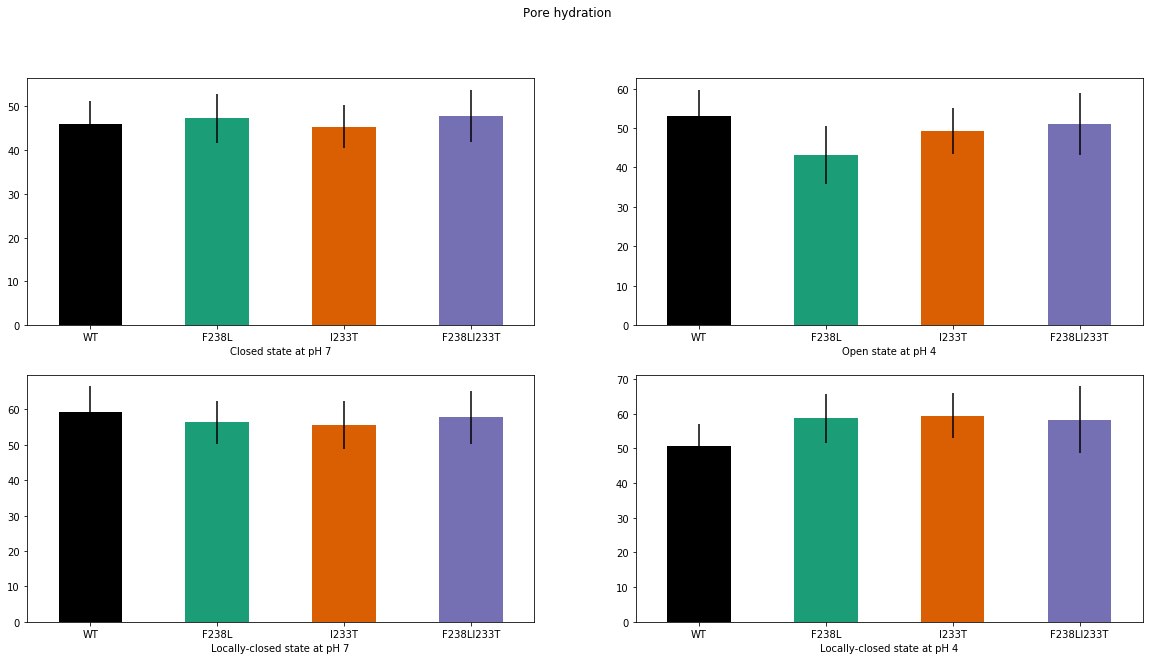

In [64]:
fig, ax = plt.subplots(2,2,figsize=(20, 10))

group = md_4NPQ_70.groupby(['MD_name','pH'],sort=False)['hydration_data_intra_new']
mean = group.mean()
errors = group.std()
mean.plot.bar(yerr=errors,ax=ax[0,0],color=['black','#1b9e77','#d95f02','#7570b3'])
ax[0,0].set_xticklabels(['WT','F238L','I233T','F238LI233T'],fontdict)
ax[0,0].set_xlabel('Closed state at pH 7')

group = md_4HFI_46.groupby(['MD_name','pH'],sort=False)['hydration_data_intra_new']
mean = group.mean()
errors = group.std()
mean.plot.bar(yerr=errors,ax=ax[0,1],color=['black','#1b9e77','#d95f02','#7570b3'])
ax[0,1].set_xticklabels(['WT','F238L','I233T','F238LI233T'],fontdict)
ax[0,1].set_xlabel('Open state at pH 4')

group = md_5NJY_70.groupby(['MD_name','pH'],sort=False)['hydration_data_intra_new']
mean = group.mean()
errors = group.std()
mean.plot.bar(yerr=errors,ax=ax[1,0],color=['black','#1b9e77','#d95f02','#7570b3'])
ax[1,0].set_xticklabels(['WT','F238L','I233T','F238LI233T'],fontdict)
ax[1,0].set_xlabel('Locally-closed state at pH 7')

group = md_5NJY_46.groupby(['MD_name','pH'],sort=False)['hydration_data_intra_new']
mean = group.mean()
errors = group.std()
mean.plot.bar(yerr=errors,ax=ax[1,1],color=['black','#1b9e77','#d95f02','#7570b3'])
ax[1,1].set_xticklabels(['WT','F238L','I233T','F238LI233T'],fontdict)
ax[1,1].set_xlabel('Locally-closed state at pH 4')
#ax[0,0].set_ylim(0,20)
#ax[0,1].set_ylim(0,20)
#ax[1,0].set_ylim(0,20)
#ax[1,1].set_ylim(0,20)

plt.suptitle('Pore hydration')
#plt.savefig('plots/pore_hydration_2.pdf')

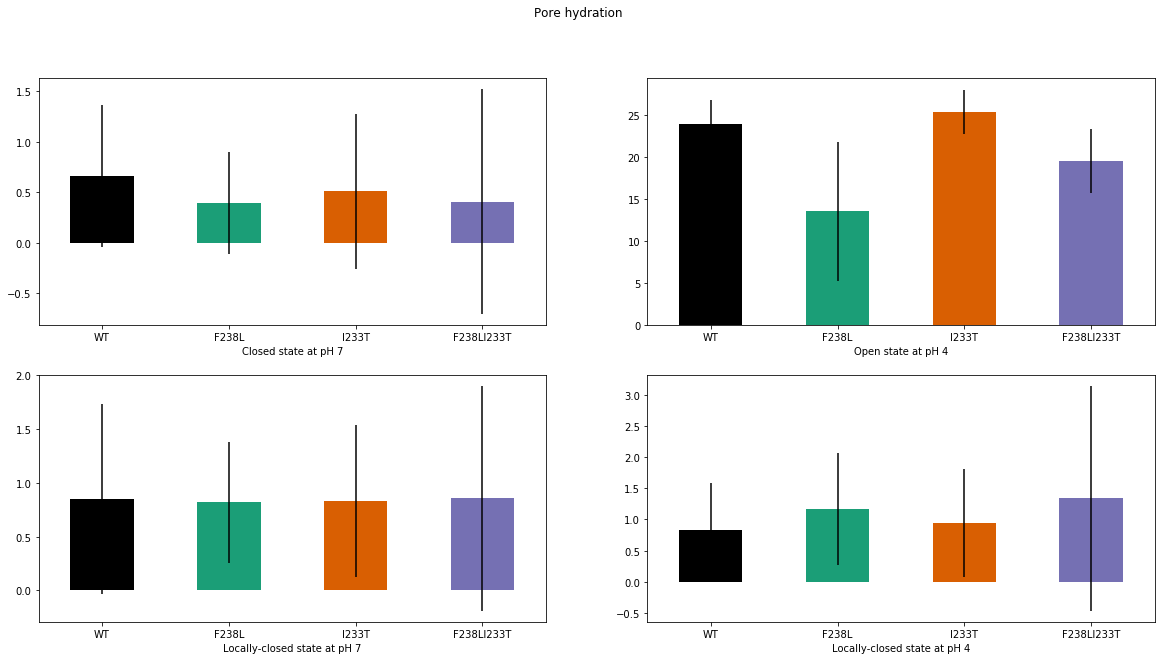

In [65]:
fig, ax = plt.subplots(2,2,figsize=(20, 10))

group = md_4NPQ_70.groupby(['MD_name','pH'],sort=False)['hydration_data_inter_new']
mean = group.mean()
errors = group.std()
mean.plot.bar(yerr=errors,ax=ax[0,0],color=['black','#1b9e77','#d95f02','#7570b3'])
ax[0,0].set_xticklabels(['WT','F238L','I233T','F238LI233T'],fontdict)
ax[0,0].set_xlabel('Closed state at pH 7')

group = md_4HFI_46.groupby(['MD_name','pH'],sort=False)['hydration_data_inter_new']
mean = group.mean()
errors = group.std()
mean.plot.bar(yerr=errors,ax=ax[0,1],color=['black','#1b9e77','#d95f02','#7570b3'])
ax[0,1].set_xticklabels(['WT','F238L','I233T','F238LI233T'],fontdict)
ax[0,1].set_xlabel('Open state at pH 4')

group = md_5NJY_70.groupby(['MD_name','pH'],sort=False)['hydration_data_inter_new']
mean = group.mean()
errors = group.std()
mean.plot.bar(yerr=errors,ax=ax[1,0],color=['black','#1b9e77','#d95f02','#7570b3'])
ax[1,0].set_xticklabels(['WT','F238L','I233T','F238LI233T'],fontdict)
ax[1,0].set_xlabel('Locally-closed state at pH 7')

group = md_5NJY_46.groupby(['MD_name','pH'],sort=False)['hydration_data_inter_new']
mean = group.mean()
errors = group.std()
mean.plot.bar(yerr=errors,ax=ax[1,1],color=['black','#1b9e77','#d95f02','#7570b3'])
ax[1,1].set_xticklabels(['WT','F238L','I233T','F238LI233T'],fontdict)
ax[1,1].set_xlabel('Locally-closed state at pH 4')
#ax[0,0].set_ylim(0,20)
#ax[0,1].set_ylim(0,20)
#ax[1,0].set_ylim(0,20)
#ax[1,1].set_ylim(0,20)

plt.suptitle('Pore hydration')
#plt.savefig('plots/pore_hydration_2.pdf')

In [94]:
def create_hydration_profile_non_pore_intra(md_data = None):
    def append_hydration_data(traj_note,location = '/media/scottzhuang/data/MD/', skip=10):
        top_location = traj_note + '/' + traj_note + ".system.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".system.xtc"
        traj = mda.Universe(location + top_location,location + traj_location)
        hydration = traj.select_atoms("(cylayer 7 20 8 -8 resid 235) and name OW and (around 15 resid 304)",updating = True)
        for i in range(0,traj.trajectory.n_frames):
            traj.trajectory[i]
            hydration_data.append(hydration.n_atoms)
    hydration_data = []
    for traj_note in traj_notes:
        append_hydration_data(traj_note)
    md_data['hydration_data_intra'] = hydration_data

In [95]:
def create_hydration_profile_non_pore_inter(md_data = None):
    def append_hydration_data(traj_note,location = '/media/scottzhuang/data/MD/', skip=10):
        top_location = traj_note + '/' + traj_note + ".system.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".system.xtc"
        traj = mda.Universe(location + top_location,location + traj_location)
        hydration = traj.select_atoms("(cylayer 7 20 8 -8 resid 235) and name OW and not(around 15 resid 304)",updating = True)
        for i in range(0,traj.trajectory.n_frames):
            traj.trajectory[i]
            hydration_data.append(hydration.n_atoms)
    hydration_data = []
    for traj_note in traj_notes:
        append_hydration_data(traj_note)
    md_data['hydration_data_inter'] = hydration_data

In [82]:
def create_distance_238_246(md_data = None):

    def cappend_distance_238_246(traj_note,location = '/media/scottzhuang/data/MD/', skip=10):
        top_location = traj_note + '/' + traj_note + ".protein.gro"
        traj_location = traj_note + '/' + traj_note + ".skip" + str(skip) + ".protein.xtc"
        traj = md.load(location + traj_location,top = location + top_location)
        topology = traj.topology
        traj = traj.atom_slice(topology.select('(resSeq 238 and name CG) or (resSeq 246 and name CG)'))

        distance = []
        for chain in [0,2,4,6,8]:
            distance.append(md.compute_contacts(traj,[[chain,chain+1]])[0].T)
        contact_238_246.extend(np.mean(distance,axis=0).T)
    contact_238_246 = []
    for traj_note in traj_notes:
        cappend_distance_238_246(traj_note)
    md_data['contact_238_246'] = np.asarray(contact_238_246).T[0]

In [83]:
create_distance_238_246(md_data)

In [84]:
fontdict = {
            'rotation':'horizontal',
            'fontname':'Helvetica',
                 'size'   : 13

        }
labelfont = {'fontname':'Helvetica',
             'size'   : 15
            }
titlefont = {'fontname':'Helvetica',
            'weight' : 'bold',
             'size'   : 18
            }
lineplot = {'linewidth':3.0}
titleon = True

In [85]:
md_5NJY_70 = md_data[(md_data.system >= 0) & (md_data.system <= 3)]
md_5NJY_46 = md_data[(md_data.system >= 4) & (md_data.system <= 7)]
md_4HFI_46 = md_data[(md_data.system >= 8) & (md_data.system <= 11)]
md_4NPQ_70 = md_data[(md_data.system >= 12) & (md_data.system <= 15)]

In [86]:
md_WT = md_data[~md_data.MD_name.str.contains('F238L') & ~md_data.MD_name.str.contains('I233T')]
md_F238L = md_data[md_data.MD_name.str.contains('F238L') & ~md_data.MD_name.str.contains('F238LI233T')]
md_I233T = md_data[md_data.MD_name.str.contains('I233T') & ~md_data.MD_name.str.contains('F238LI233T')]
md_F238LI233T = md_data[md_data.MD_name.str.contains('F238LI233T')]

(0.7, 1.5)

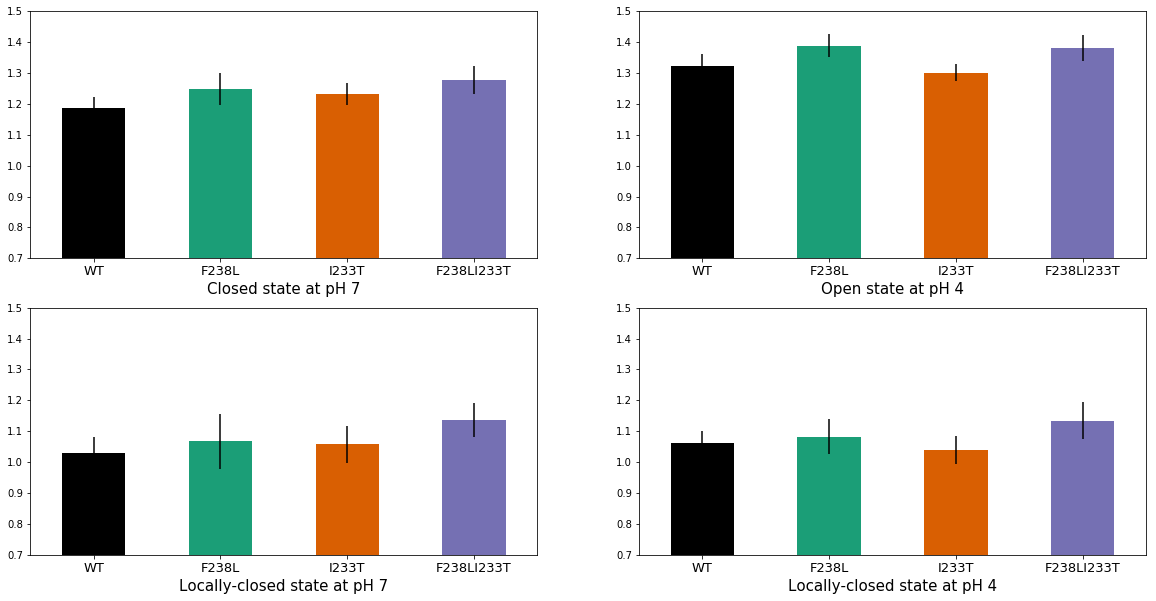

In [88]:
fig, ax = plt.subplots(2,2,figsize=(20, 10))

group = md_4NPQ_70.groupby(['MD_name','pH'],sort=False)['contact_238_246']
mean = group.mean()
errors = group.std()
mean.plot.bar(yerr=errors,ax=ax[0,0],color=['black','#1b9e77','#d95f02','#7570b3'])
ax[0,0].set_xticklabels(['WT','F238L','I233T','F238LI233T'],fontdict)
ax[0,0].set_xlabel('Closed state at pH 7',**labelfont)

group = md_4HFI_46.groupby(['MD_name','pH'],sort=False)['contact_238_246']
mean = group.mean()
errors = group.std()
mean.plot.bar(yerr=errors,ax=ax[0,1],color=['black','#1b9e77','#d95f02','#7570b3'])
ax[0,1].set_xticklabels(['WT','F238L','I233T','F238LI233T'],fontdict)
ax[0,1].set_xlabel('Open state at pH 4',**labelfont)

group = md_5NJY_70.groupby(['MD_name','pH'],sort=False)['contact_238_246']
mean = group.mean()
errors = group.std()
mean.plot.bar(yerr=errors,ax=ax[1,0],color=['black','#1b9e77','#d95f02','#7570b3'])
ax[1,0].set_xticklabels(['WT','F238L','I233T','F238LI233T'],fontdict)
ax[1,0].set_xlabel('Locally-closed state at pH 7',**labelfont)

group = md_5NJY_46.groupby(['MD_name','pH'],sort=False)['contact_238_246']
mean = group.mean()
errors = group.std()
mean.plot.bar(yerr=errors,ax=ax[1,1],color=['black','#1b9e77','#d95f02','#7570b3'])
ax[1,1].set_xticklabels(['WT','F238L','I233T','F238LI233T'],fontdict)
ax[1,1].set_xlabel('Locally-closed state at pH 4',**labelfont)
ax[0,0].set_ylim(0.7,1.5)
ax[0,1].set_ylim(0.7,1.5)
ax[1,0].set_ylim(0.7,1.5)
ax[1,1].set_ylim(0.7,1.5)
#if titleon:

#    plt.suptitle('M2 M1 distance')
#plt.savefig('plots/m2_m1_distance_bar.pdf')

In [32]:
md_data = pd.read_csv("glic_gating.csv")

In [36]:
md_data.to_csv("glic_gating.csv")

In [61]:
md_data = create_md_dataframe()
create_metadata(md_data= md_data)
create_system_notation(md_data = md_data)
create_rmsd_data(md_data= md_data)

In 5NJY_pH70_md1, simulation runs 1030 ns.
In 5NJY_pH70_md2, simulation runs 750 ns.
In 5NJY_pH70_md3, simulation runs 810 ns.
In 5NJY_F238L_pH70_md1, simulation runs 540 ns.
In 5NJY_F238L_pH70_md2, simulation runs 680 ns.
In 5NJY_F238L_pH70_md3, simulation runs 720 ns.
In 5NJY_I233T_pH70_md4, simulation runs 730 ns.
In 5NJY_I233T_pH70_md2, simulation runs 590 ns.
In 5NJY_I233T_pH70_md3, simulation runs 820 ns.
In 5NJY_F238LI233T_pH70_md1, simulation runs 830 ns.
In 5NJY_F238LI233T_pH70_md2, simulation runs 800 ns.
In 5NJY_F238LI233T_pH70_md3, simulation runs 880 ns.
In 5NJY_pH46_md1, simulation runs 780 ns.
In 5NJY_pH46_md2, simulation runs 1060 ns.
In 5NJY_pH46_md3, simulation runs 1030 ns.
In 5NJY_F238L_pH46_md1, simulation runs 930 ns.
In 5NJY_F238L_pH46_md2, simulation runs 950 ns.
In 5NJY_F238L_pH46_md3, simulation runs 1090 ns.
In 5NJY_I233T_pH46_md1, simulation runs 810 ns.
In 5NJY_I233T_pH46_md2, simulation runs 870 ns.
In 5NJY_I233T_pH46_md3, simulation runs 980 ns.
In 5NJY_F

In [125]:
create_cluster_data(md_data)

In [112]:
create_rmsd_data(md_data,'4NPQ')

In [113]:
create_rmsd_data(md_data,'4HFI')

In [114]:
create_rmsd_data(md_data,'5NJY')

In [118]:
create_rmsd_data(md_data,select_domain='TMD')

In [119]:
create_rmsd_data(md_data,select_domain='ECD')

In [120]:
create_rmsd_data(md_data)

In [62]:
create_cppca_data(md_data)

In [70]:
create_pca_data(md_data)

In [85]:
create_domain_twist_data(md_data)
create_helix_tilt_data(md_data)
create_helix_twist_data(md_data)

In [86]:
create_beta_expansion(md_data)
create_M2_radius(md_data)
create_ECD_radius(md_data)
create_M2_M1_distance(md_data)
create_M1_kink(md_data)

In [ ]:
create_hydration_profile(md_data)

In [104]:
create_hydration_profile_resid(md_data)
create_hydration_profile_non_pore(md_data)

In [105]:
create_pore_profile(md_data)

In [122]:
md_data = md_data.drop(columns=['rmsdNone'])

In [160]:
md_data = pd.read_pickle("glic_gating.pickle")

In [217]:
md_data.to_pickle("glic_gating.pickle")

In [195]:
md_data.columns

Index(['MD_name', 'pH', 'replicate', 'traj_time', 'system', 'ecd_pc1',
       'ecd_pc2', 'tmd_pc1', 'tmd_pc2', 'wholepca_pc1', 'wholepca_pc2',
       'wholepca_pc3', 'wholepca_pc4', 'wholepca_pc5', 'domain twist',
       'helix tilt angle', 'helix twist angle', 'beta_expansion', 'M2_radius',
       'ECD_radius', 'M2_M1_distance', 'M1_kink', 'hydration_data',
       'hydration_data235_3a', 'hydration_data233_3a', 'hydration_data238_3a',
       'hydration_data226_3a', 'hydration_data240_3a', 'hydration_data_m123',
       'pore_profile_222', 'pore_profile_226', 'pore_profile_230',
       'pore_profile_233', 'pore_profile_237', 'pore_profile_240', 'rmsd4NPQ',
       'rmsd4HFI', 'rmsd5NJY', 'tmd_rmsd', 'ecd_rmsd', 'rmsd', 'cluster_index',
       'ECD twist', 'hydration_data_236_center', 'tmd_noM2_pc1',
       'tmd_noM2_pc2', 'rmsd_TMD_noM2', 'contact_238_246',
       'ecd_pc1_no_expansion', 'ecd_pc2_no_expansion', 'dbscan', 'm2_pc1',
       'm2_pc2', 'm2_pc3', 'm2_pc4', 'm2_pc5'],
      dty

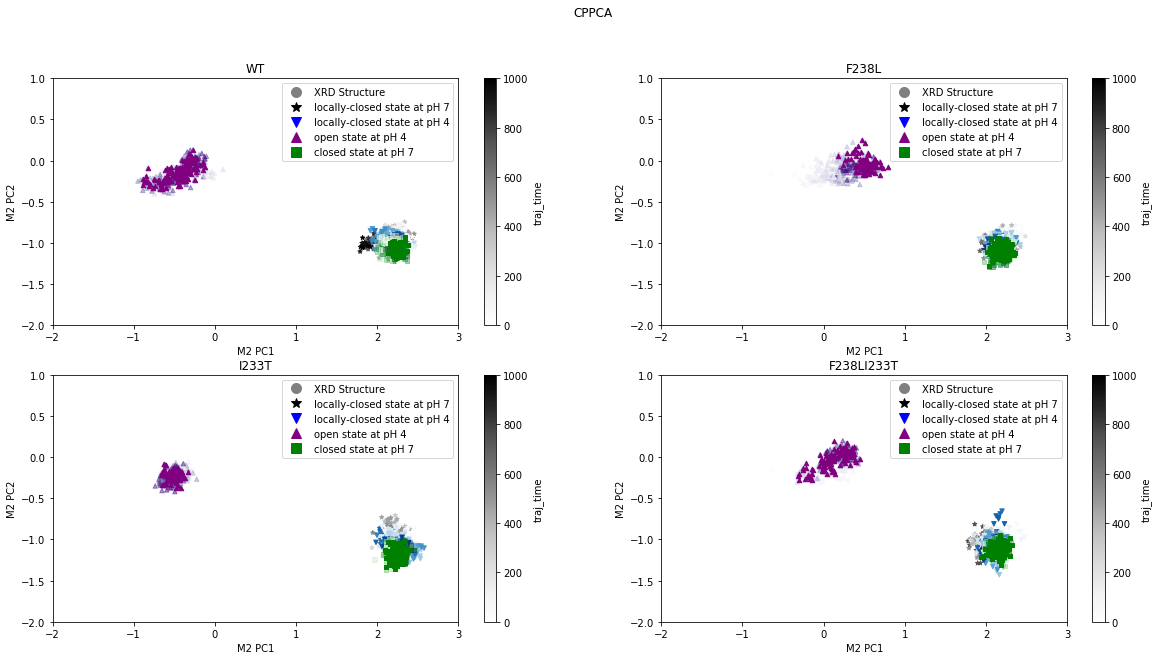

In [198]:
fig, ax = plt.subplots(2,2,figsize=(20, 10))
md_data = pd.read_pickle('glic_gating.pickle')
md_data['traj_time'] = md_data['traj_time'] * 10
md_5NJY_70 = md_data[(md_data.system >= 0) & (md_data.system <= 3)]
md_5NJY_46 = md_data[(md_data.system >= 4) & (md_data.system <= 7)]
md_4HFI_46 = md_data[(md_data.system >= 8) & (md_data.system <= 11)]
md_4NPQ_70 = md_data[(md_data.system >= 12) & (md_data.system <= 15)]
md_WT = md_data[~md_data.MD_name.str.contains('F238L') & ~md_data.MD_name.str.contains('I233T')]
md_F238L = md_data[md_data.MD_name.str.contains('F238L') & ~md_data.MD_name.str.contains('F238LI233T')]
md_I233T = md_data[md_data.MD_name.str.contains('I233T') & ~md_data.MD_name.str.contains('F238LI233T')]
md_F238LI233T = md_data[md_data.MD_name.str.contains('F238LI233T')]

#md_data.plot(kind="scatter",x="ecd_pc1",y="tmd_pc1",c=['#a6611a','#7b3294','#0571b0','#018571'],ax=axes,alpha=0.2)
md_WT[md_WT.system == 0 ].plot(kind="scatter",x="m2_pc1",y="m2_pc2",c='traj_time',ax=ax[0,0],marker='*',colormap='Greys',vmin=0,vmax=1000)
md_WT[md_WT.system == 4 ].plot(kind="scatter",x="m2_pc1",y="m2_pc2",c='traj_time',ax=ax[0,0],marker='v',colormap='Blues',colorbar=None)
md_WT[md_WT.system == 8 ].plot(kind="scatter",x="m2_pc1",y="m2_pc2",c='traj_time',ax=ax[0,0],marker='^',colormap='Purples',colorbar=None,alpha=0.5)
md_WT[md_WT.system == 12 ].plot(kind="scatter",x="m2_pc1",y="m2_pc2",c='traj_time',ax=ax[0,0],marker='s',colormap='Greens',colorbar=None,alpha=0.5)

md_F238L[md_F238L.system == 1 ].plot(kind="scatter",x="m2_pc1",y="m2_pc2",c='traj_time',ax=ax[0,1],marker='*',colormap='Greys',vmin=0,vmax=1000)
md_F238L[md_F238L.system == 5 ].plot(kind="scatter",x="m2_pc1",y="m2_pc2",c='traj_time',ax=ax[0,1],marker='v',colormap='Blues',colorbar=None)
md_F238L[md_F238L.system == 9 ].plot(kind="scatter",x="m2_pc1",y="m2_pc2",c='traj_time',ax=ax[0,1],marker='^',colormap='Purples',colorbar=None,alpha=0.5)
md_F238L[md_F238L.system == 13 ].plot(kind="scatter",x="m2_pc1",y="m2_pc2",c='traj_time',ax=ax[0,1],marker='s',colormap='Greens',colorbar=None,alpha=0.5)

md_I233T[md_I233T.system == 2 ].plot(kind="scatter",x="m2_pc1",y="m2_pc2",c='traj_time',ax=ax[1,0],marker='*',colormap='Greys',vmin=0,vmax=1000)
md_I233T[md_I233T.system == 6 ].plot(kind="scatter",x="m2_pc1",y="m2_pc2",c='traj_time',ax=ax[1,0],marker='v',colormap='Blues',colorbar=None)
md_I233T[md_I233T.system == 10 ].plot(kind="scatter",x="m2_pc1",y="m2_pc2",c='traj_time',ax=ax[1,0],marker='^',colormap='Purples',colorbar=None,alpha=0.5)
md_I233T[md_I233T.system == 14 ].plot(kind="scatter",x="m2_pc1",y="m2_pc2",c='traj_time',ax=ax[1,0],marker='s',colormap='Greens',colorbar=None,alpha=0.5)

md_F238LI233T[md_F238LI233T.system == 3 ].plot(kind="scatter",x="m2_pc1",y="m2_pc2",c='traj_time',ax=ax[1,1],marker='*',colormap='Greys',vmin=0,vmax=1000)
md_F238LI233T[md_F238LI233T.system == 7 ].plot(kind="scatter",x="m2_pc1",y="m2_pc2",c='traj_time',ax=ax[1,1],marker='v',colormap='Blues',colorbar=None)
md_F238LI233T[md_F238LI233T.system == 11 ].plot(kind="scatter",x="m2_pc1",y="m2_pc2",c='traj_time',ax=ax[1,1],marker='^',colormap='Purples',colorbar=None,alpha=0.5)
md_F238LI233T[md_F238LI233T.system == 15 ].plot(kind="scatter",x="m2_pc1",y="m2_pc2",c='traj_time',ax=ax[1,1],marker='s',colormap='Greens',colorbar=None,alpha=0.5)


md_data = md_data[md_data.dbscan == 0]
md_5NJY_70 = md_data[(md_data.system >= 0) & (md_data.system <= 3)]
md_5NJY_46 = md_data[(md_data.system >= 4) & (md_data.system <= 7)]
md_4HFI_46 = md_data[(md_data.system >= 8) & (md_data.system <= 11)]
md_4NPQ_70 = md_data[(md_data.system >= 12) & (md_data.system <= 15)]
md_WT = md_data[~md_data.MD_name.str.contains('F238L') & ~md_data.MD_name.str.contains('I233T')]
md_F238L = md_data[md_data.MD_name.str.contains('F238L') & ~md_data.MD_name.str.contains('F238LI233T')]
md_I233T = md_data[md_data.MD_name.str.contains('I233T') & ~md_data.MD_name.str.contains('F238LI233T')]
md_F238LI233T = md_data[md_data.MD_name.str.contains('F238LI233T')]

md_WT[md_WT.system == 8 ].plot(kind="scatter",x="m2_pc1",y="m2_pc2",c='purple',ax=ax[0,0],marker='^',colorbar=None)
md_WT[md_WT.system == 12 ].plot(kind="scatter",x="m2_pc1",y="m2_pc2",c='green',ax=ax[0,0],marker='s',colorbar=None)

md_F238L[md_F238L.system == 9 ].plot(kind="scatter",x="m2_pc1",y="m2_pc2",c='purple',ax=ax[0,1],marker='^',colorbar=None)
md_F238L[md_F238L.system == 13 ].plot(kind="scatter",x="m2_pc1",y="m2_pc2",c='green',ax=ax[0,1],marker='s',colorbar=None)

md_I233T[md_I233T.system == 10 ].plot(kind="scatter",x="m2_pc1",y="m2_pc2",c='purple',ax=ax[1,0],marker='^',colorbar=None)
md_I233T[md_I233T.system == 14 ].plot(kind="scatter",x="m2_pc1",y="m2_pc2",c='green',ax=ax[1,0],marker='s',colorbar=None)

md_F238LI233T[md_F238LI233T.system == 11 ].plot(kind="scatter",x="m2_pc1",y="m2_pc2",c='purple',ax=ax[1,1],marker='^',colorbar=None)
md_F238LI233T[md_F238LI233T.system == 15 ].plot(kind="scatter",x="m2_pc1",y="m2_pc2",c='green',ax=ax[1,1],marker='s',colorbar=None)

colors = {'WT':'black', 'F238L':'#1b9e77', 'I233T':'#d95f02', 'F238LI233T':'#7570b3'}
#option={'ms':10}

#plt.scatter(mean1.loc[0:3].ecd_pc1,mean1.loc[0:3].tmd_pc1,c=['black','#1b9e77','#d95f02','#7570b3'],marker='*',s=300)
#plt.scatter(mean1.loc[4:7].ecd_pc1,mean1.loc[4:7].tmd_pc1,c=['black','#1b9e77','#d95f02','#7570b3'],marker='v',s=200)
#plt.scatter(mean1.loc[8:11].ecd_pc1,mean1.loc[8:11].tmd_pc1,c=['black','#1b9e77','#d95f02','#7570b3'],marker='^',s=200)
#plt.scatter(mean1.loc[12:15].ecd_pc1,mean1.loc[12:15].tmd_pc1,c=['black','#1b9e77','#d95f02','#7570b3'],marker='s',s=200)

#ax[0,0].scatter(pcca_reduced_cartesian[0], pcca_reduced_cartesian[1],c='grey',marker='o',s=30)
#ax[0,1].scatter(pcca_reduced_cartesian[0], pcca_reduced_cartesian[1],c='grey',marker='o',s=30)
#ax[1,0].scatter(pcca_reduced_cartesian[0], pcca_reduced_cartesian[1],c='grey',marker='o',s=30)
#ax[1,1].scatter(pcca_reduced_cartesian[0], pcca_reduced_cartesian[1],c='grey',marker='o',s=30)

#plt.scatter(pcca_reduced_cartesian[0], pcca_reduced_cartesian[1],c='grey',marker='o',axes=ax[0,1],s=200)
#plt.scatter(pcca_reduced_cartesian[0], pcca_reduced_cartesian[1],c='grey',marker='o',ax=ax[1,0],s=200)
#plt.scatter(pcca_reduced_cartesian[0], pcca_reduced_cartesian[1],c='grey',marker='o',ax=ax[0,1],s=200)




#plt.plot(mean2.loc[4:7].ecd_pc1,mean2.loc[4:7].tmd_pc1,c=['black','#1b9e77','#d95f02','#7570b3'],marker='v',s=100)
#plt.plot(mean2.loc[8:11].ecd_pc1,mean2.loc[8:11].tmd_pc1,c=['black','#1b9e77','#d95f02','#7570b3'],marker='^',s=100)
#plt.plot(mean2.loc[12:15].ecd_pc1,mean2.loc[12:15].tmd_pc1,c=['black','#1b9e77','#d95f02','#7570b3'],marker='s',s=100)

#group = md_cluster_2.groupby(['system'])[['ecd_pc1','tmd_pc1']]
#mean = group.mean()
#plt.scatter(mean.loc[0:3].ecd_pc1,mean.loc[0:3].tmd_pc1,c=['#a6611a','#7b3294','#0571b0','#018571'],marker='*',s=400)
#plt.scatter(mean.loc[4:7].ecd_pc1,mean.loc[4:7].tmd_pc1,c=['#a6611a','#7b3294','#0571b0','#018571'],marker='v',s=300)
#plt.scatter(mean.loc[8:11].ecd_pc1,mean.loc[8:11].tmd_pc1,c=['#a6611a','#7b3294','#0571b0','#018571'],marker='^',s=300)
#plt.scatter(mean.loc[12:15].ecd_pc1,mean.loc[12:15].tmd_pc1,c=['#a6611a','#7b3294','#0571b0','#018571'],marker='s',s=300)


ax[0,0].set_xlabel('M2 PC1')
ax[0,0].set_ylabel('M2 PC2')
ax[0,0].set_xlim(-2,3)
ax[0,0].set_ylim(-2,1)
ax[0,0].set_title('WT')

ax[0,1].set_xlabel('M2 PC1')
ax[0,1].set_ylabel('M2 PC2')
ax[0,1].set_xlim(-2,3)
ax[0,1].set_ylim(-2,1)
ax[0,1].set_title('F238L')

ax[1,0].set_xlabel('M2 PC1')
ax[1,0].set_ylabel('M2 PC2')
ax[1,0].set_xlim(-2,3)
ax[1,0].set_ylim(-2,1)
ax[1,0].set_title('I233T')

ax[1,1].set_xlabel('M2 PC1')
ax[1,1].set_ylabel('M2 PC2')
ax[1,1].set_xlim(-2,3)
ax[1,1].set_ylim(-2,1)
ax[1,1].set_title('F238LI233T')

custom_lines = [Line2D([0], [0], marker='o', color='grey', label='Scatter',
                        markersize=10,linewidth= 0),
                Line2D([0], [0], marker='*', color='black', label='Scatter',
                           markersize=10,linewidth= 0),
                Line2D([0], [0], marker='v', color='blue', label='Scatter',
                          markersize=10,linewidth= 0),
                Line2D([0], [0], marker='^', color='purple', label='Scatter',
                           markersize=10,linewidth= 0),
                Line2D([0], [0], marker='s', color='green', label='Scatter',
                           markersize=10,linewidth= 0)]
ax[0,0].legend(custom_lines, ['XRD Structure','locally-closed state at pH 7','locally-closed state at pH 4','open state at pH 4','closed state at pH 7'])
ax[0,1].legend(custom_lines, ['XRD Structure','locally-closed state at pH 7','locally-closed state at pH 4','open state at pH 4','closed state at pH 7'])
ax[1,0].legend(custom_lines, ['XRD Structure','locally-closed state at pH 7','locally-closed state at pH 4','open state at pH 4','closed state at pH 7'])
ax[1,1].legend(custom_lines, ['XRD Structure','locally-closed state at pH 7','locally-closed state at pH 4','open state at pH 4','closed state at pH 7'])


from matplotlib.lines import Line2D

if titleon:

    plt.suptitle('CPPCA')
#plt.savefig('plots/cppca_all.pdf')

In [218]:
def plot_trend(plot_x,plot_y):
    fig, axes = plt.subplots(2, 2,figsize=(20, 10))

    for system in [0,1,2,3]:
        if system == 0:
            option = {'label':'locally-closed state WT at pH 7'}
            option['c'] = 'black'
        if system == 1:
            option = {'label':'locally-closed state F238L at pH 7'}
            option['c'] = '#1b9e77' 
        if system == 2:
            option = {'label':'locally-closed state I233T at pH 7'}
            option['c'] = '#d95f02' 
        if system == 3:
            option = {'label':'locally-closed state F238LI233T at pH 7'}
            option['c'] = '#7570b3' 

        group = md_data[md_data['system'] == system].groupby([plot_x])[plot_y]
        mean = group.mean()
        errors = group.std()
        mean.plot(yerr=errors,ax=axes[1,0],**option,**lineplot)


    for system in [4,5,6,7]:
        if system == 4:
            option = {'label':'locally-closed state WT at pH 4'}
            option['c'] = 'black'
        if system == 5:
            option = {'label':'locally-closed state F238L at pH 4'}
            option['c'] = '#1b9e77' 
        if system == 6:
            option = {'label':'locally-closed state I233T at pH 4'}
            option['c'] = '#d95f02' 
        if system == 7:
            option = {'label':'locally-closed state F238LI233T at pH 4'}
            option['c'] = '#7570b3' 

        group = md_data[md_data['system'] == system].groupby([plot_x])[plot_y]
        mean = group.mean()
        errors = group.std()
        mean.plot(yerr=errors,ax=axes[1,1],**option,**lineplot)

    for system in [8,9,10,11]:
        if system == 8:
            option = {'label':'open state WT at pH 4'}
            option['c'] = 'black'
        if system == 9:
            option = {'label':'open state F238L at pH 4'}
            option['c'] = '#1b9e77' 
        if system == 10:
            option = {'label':'open state I233T at pH 4'}
            option['c'] = '#d95f02' 
        if system == 11:
            option = {'label':'open state F238LI233T at pH 4'}
            option['c'] = '#7570b3' 

        group = md_data[md_data['system'] == system].groupby([plot_x])[plot_y]
        mean = group.mean()
        errors = group.std()

        mean.plot(yerr=errors,ax=axes[0,1],**option,**lineplot)

    for system in [12,13,14,15]:
        if system == 12:
            option = {'label':'closed state WT at pH 7'}
            option['c'] = 'black'
        if system == 13:
            option = {'label':'closed state F238L at pH 7'}
            option['c'] = '#1b9e77' 
        if system == 14:
            option = {'label':'closed state I233T at pH 7'}
            option['c'] = '#d95f02' 
        if system == 15:
            option = {'label':'closed state F238LI233T at pH 7'}
            option['c'] = '#7570b3' 

        group = md_data[md_data['system'] == system].groupby([plot_x])[plot_y]
        mean = group.mean()
        errors = group.std()
        mean.plot(yerr=errors,ax=axes[0,0],**option,**lineplot)

    axes[0,0].set_xlim(0,800)
    axes[0,1].set_xlim(0,800)
    axes[1,0].set_xlim(0,800)
    axes[1,1].set_xlim(0,800)

    axes[0,0].legend()
    axes[0,1].legend()
    axes[1,0].legend()
    axes[1,1].legend()

    axes[0,0].set_xlabel('Times (ns)')
    axes[0,0].set_ylabel(plot_y)
    axes[0,1].set_xlabel('Times (ns)')
    axes[0,1].set_ylabel(plot_y)
    axes[1,0].set_xlabel('Times (ns)')
    axes[1,0].set_ylabel(plot_y)
    axes[1,1].set_xlabel('Times (ns)')
    axes[1,1].set_ylabel(plot_y)
    plt.suptitle(plot_y)
    plt.show()

In [219]:
md_data.columns

Index(['MD_name', 'pH', 'replicate', 'traj_time', 'system', 'ecd_pc1',
       'ecd_pc2', 'tmd_pc1', 'tmd_pc2', 'wholepca_pc1', 'wholepca_pc2',
       'wholepca_pc3', 'wholepca_pc4', 'wholepca_pc5', 'domain twist',
       'helix tilt angle', 'helix twist angle', 'beta_expansion', 'M2_radius',
       'ECD_radius', 'M2_M1_distance', 'M1_kink', 'hydration_data',
       'hydration_data235_3a', 'hydration_data233_3a', 'hydration_data238_3a',
       'hydration_data226_3a', 'hydration_data240_3a', 'hydration_data_m123',
       'pore_profile_222', 'pore_profile_226', 'pore_profile_230',
       'pore_profile_233', 'pore_profile_237', 'pore_profile_240', 'rmsd4NPQ',
       'rmsd4HFI', 'rmsd5NJY', 'tmd_rmsd', 'ecd_rmsd', 'rmsd', 'cluster_index',
       'ECD twist', 'hydration_data_236_center', 'tmd_noM2_pc1',
       'tmd_noM2_pc2', 'rmsd_TMD_noM2', 'contact_238_246',
       'ecd_pc1_no_expansion', 'ecd_pc2_no_expansion', 'dbscan',
       'M2_M1_distance_1', 'M2_M1_distance_2', 'M2_M1_distance_3',


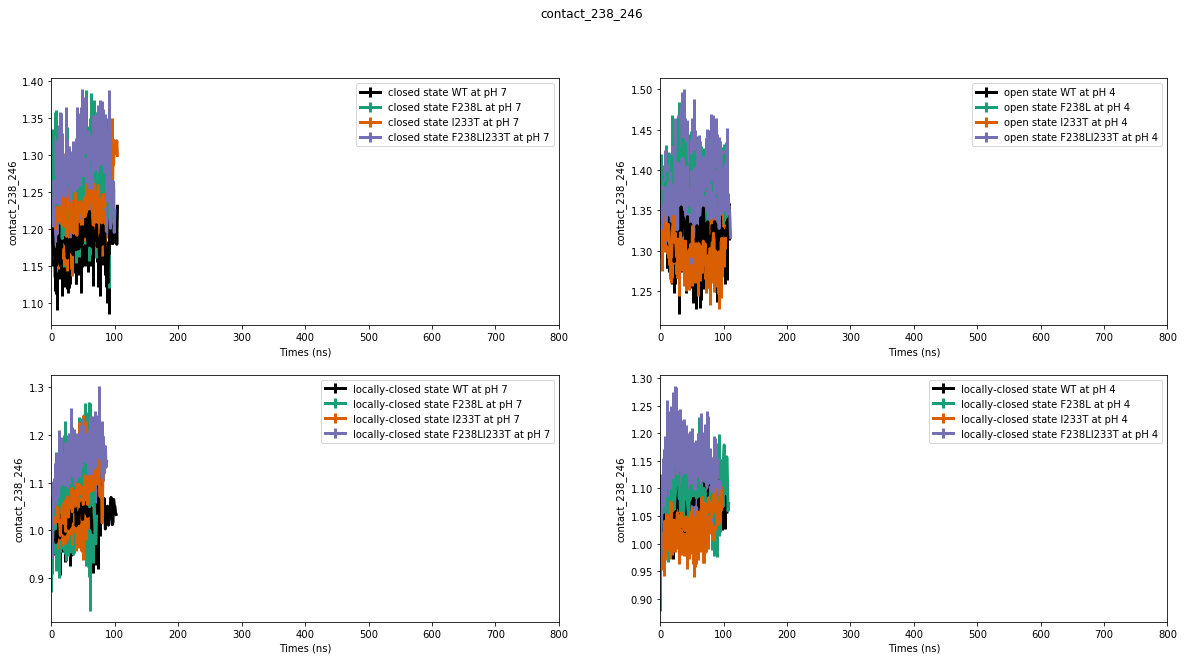

In [220]:
plot_trend('traj_time','contact_238_246')